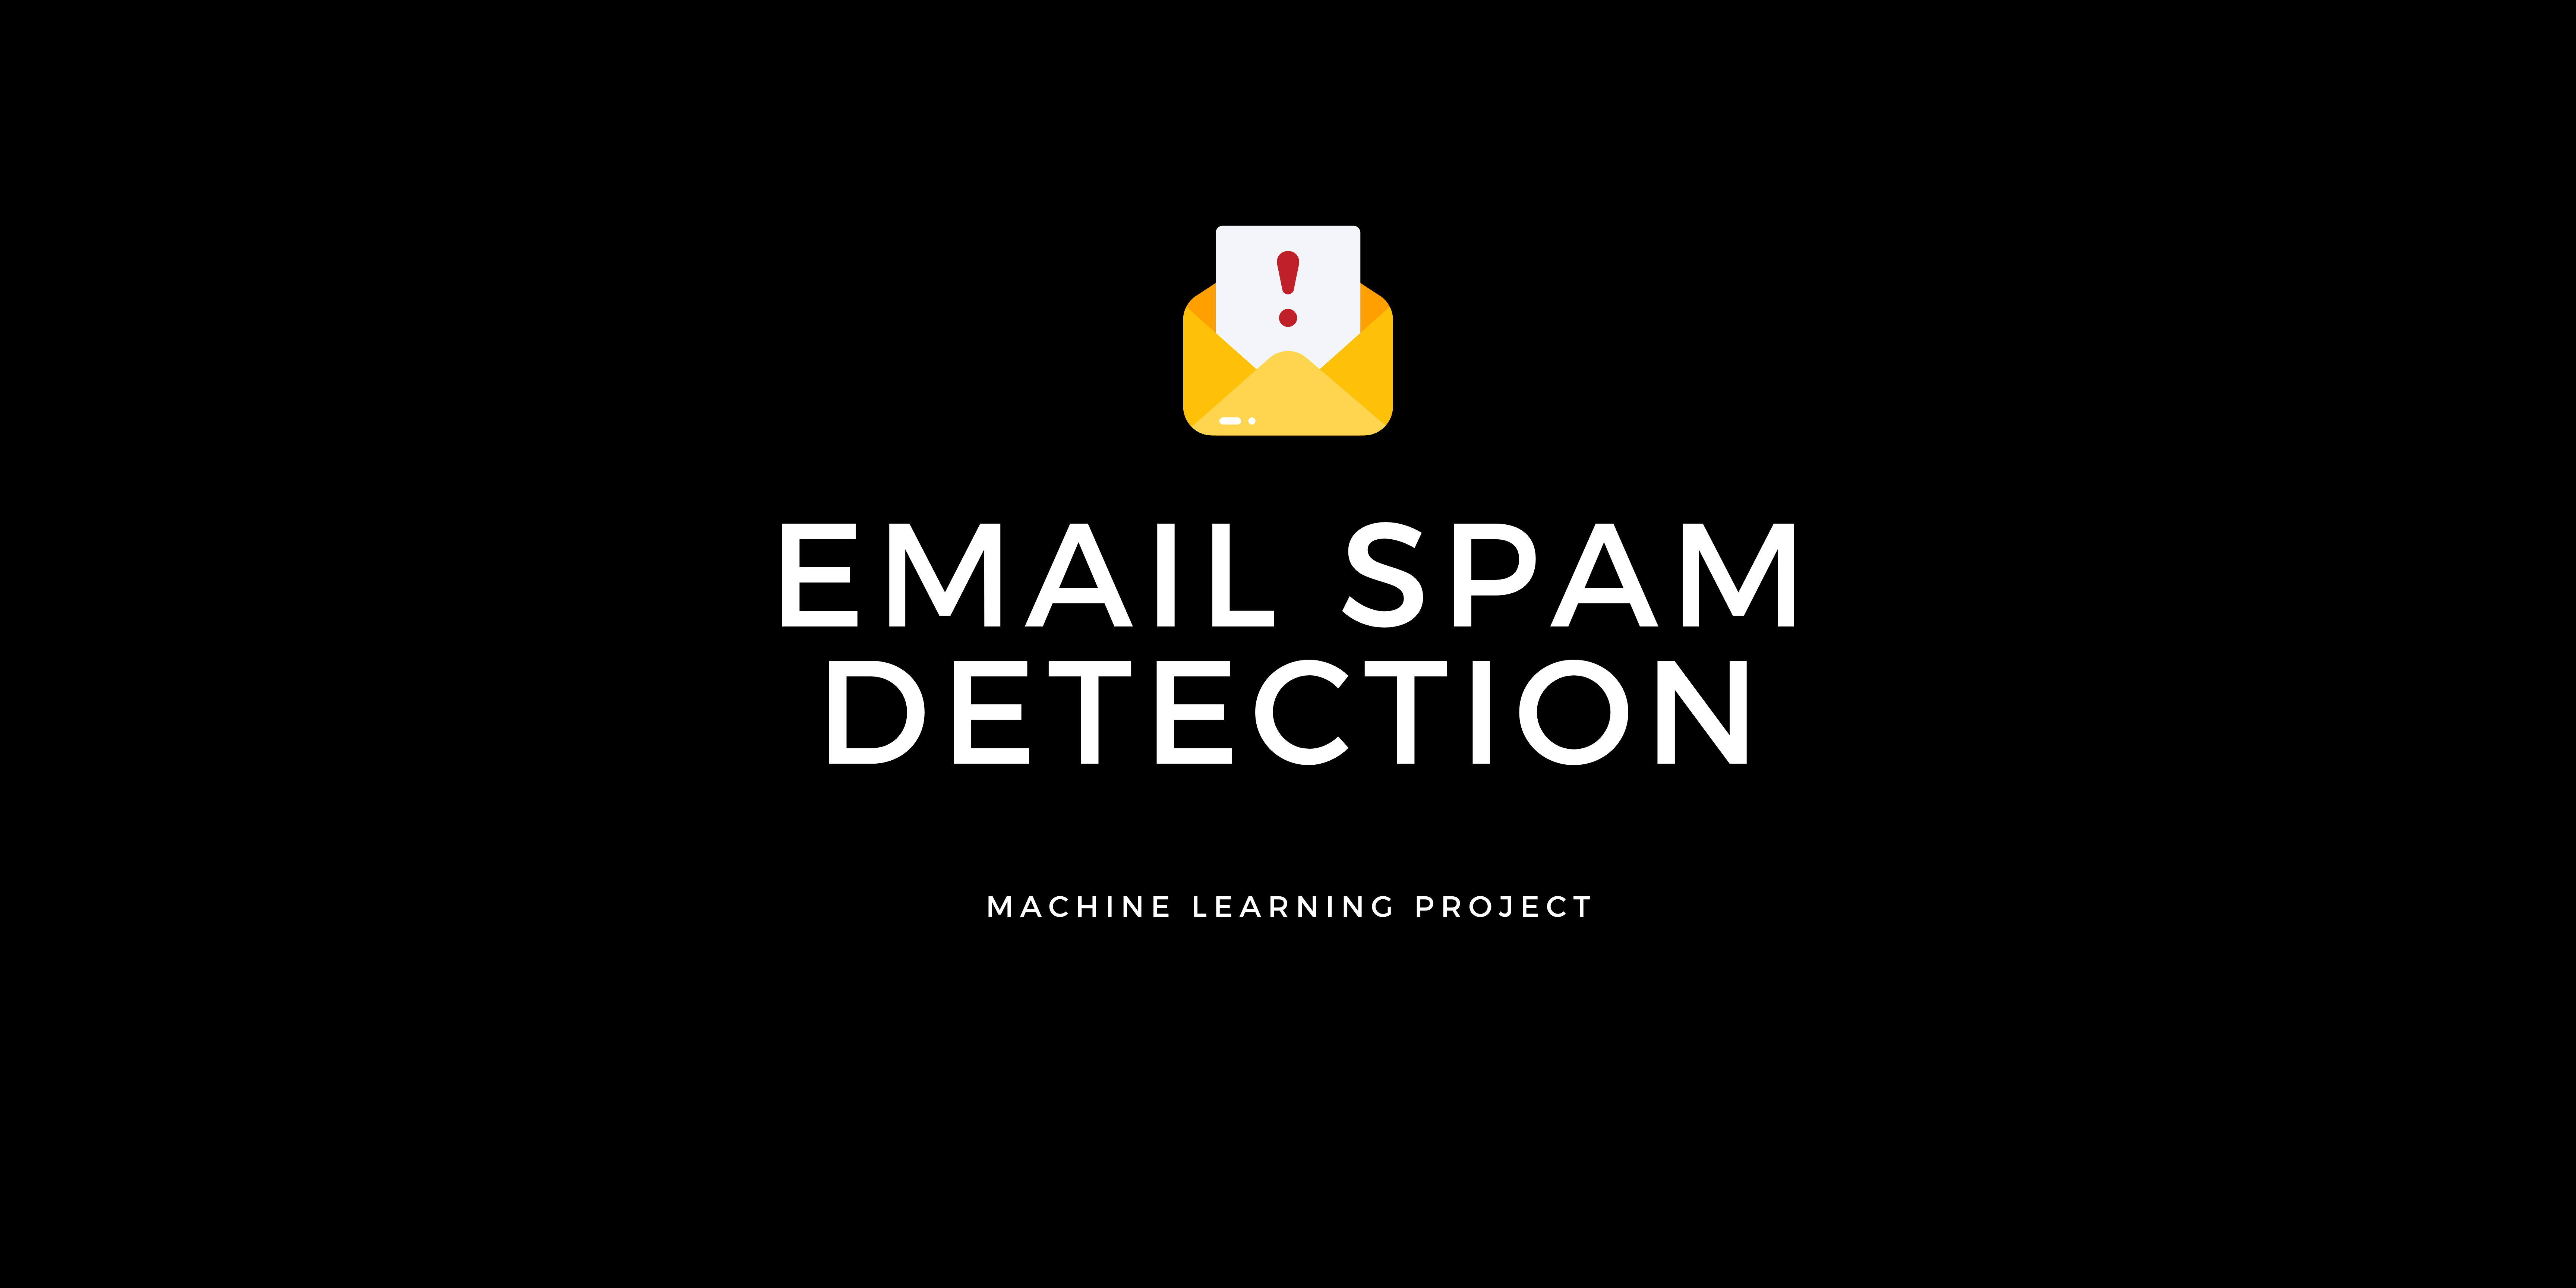

This project follows the process of building a spam email detection model using machine learning techniques. 

**Spam detection** is a key task in natural language processing (NLP) that aims to identify whether a given message (e.g., email, text, or comment) is **spam** or **non-spam** (also referred to as **ham**). As the volume of digital communication increases, it's crucial for both individuals and businesses to filter out irrelevant and unwanted content, such as promotional emails, phishing attempts, or malicious attachments.<br>

The primary goal of a **spam detection model** is to accurately classify incoming messages as either spam or non-spam. This helps in improving user experience by reducing the clutter of unwanted messages.

**Why Spam Detection is Important**

- **Security and Safety:** Spam messages often contain links to phishing sites or malware. By detecting spam early, users can avoid being exposed to potential security threats.
- **Improved Productivity:** Automatically filtering out spam emails or messages helps users focus on legitimate and important content.
- **Better User Experience:** Ensuring that spam content doesn't reach users improves their overall experience and engagement with the platform or service.
  
### **Dataset Overview:**

For this project, we'll be using a dataset of emails that are labeled as either spam or non-spam(ham). The dataset was sourced online and typically includes the following information:

- **Text**: The content of the email which will be cleaned for clarity
- **Label**: The corresponding label, where messages are either classified as **spam** or **ham (non-spam)**.

This dataset will be used to train various machine-learning models, such as 
- Multinomial Naive Bayes: Known for its efficiency in text classification.
- Random Forest: An ensemble method that often performs well on classification tasks.
- Logistic Regression: A straightforward model for binary classification.
- Decision Tree Classifier
- ExtraTreesClassifier

These models will be used to train and test the data to evaluate their ability to classify messages as spam or ham. The best-performing model will then undergo further hyperparameter tuning to enhance its accuracy for future use.

The primary features used for training the models will be derived from the **text content** itself. These features will be processed through **text preprocessing techniques** such as removing stopwords, punctuation, and special characters, lemmatization and converted into numerical vectors using TF-IDF vectorization method.

### **Objective:**
- Develop and evaluate a predictive model that can classify messages as either spam or non-spam.
- Assess the performance of various machine learning models and select the best model based on metrics such as **accuracy**, **precision**, and **recall**.

In [1]:
# Importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
train_data = pd.read_parquet("train.parquet")

In [3]:
test_data = pd.read_parquet("test.parquet")

In [4]:
train_data.head()

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam


In [5]:
test_data.head()

,text,label
0,"Deezer.com 10,406,168 Artist DB\n\nWe have sc...",not_spam
1,🚨 ATTENTION ALL USERS! 🚨\n\n🆘 Are you looking ...,spam
2,I'm working on a stats project to test some of...,not_spam
3,"[[Sorry, I cannot generate inappropriate or sp...",spam
4,L@@k at these Unbelievable diet pills that can...,spam


In [6]:
train_data.shape

print (f'This dataset contains {train_data.shape[0]} records and {train_data.shape[1]} column')

This dataset contains 8175 records and 2 column


### Data Cleaning - Train data

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8175 entries, 0 to 8174
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8175 non-null   object
 1   label   8175 non-null   object
dtypes: object(2)
memory usage: 127.9+ KB


**To check for duplicate records in the data and remove them**

In [8]:
train_data.duplicated().sum()

133

In [9]:
train_data.drop_duplicates(inplace= True)

In [10]:
train_data.duplicated().sum()

0

In [11]:
train_data.shape

(8042, 2)

In [12]:
train_data = train_data.rename(columns = {"text": "Email", "label": "Email_Type"})

In [13]:
train_data.sample(4)

,Email,Email_Type
5991,Get rich quick with our amazing money-making p...,spam
1112,I'm just kicking off this project with a frien...,not_spam
3126,I'm interested in using machine-learning and n...,not_spam
1961,"""Get rich quick with our amazing investment pr...",spam


### Exploratory Data Analysis

1. **Distribution of Spam vs. Non-Spam** <br>
To check the class balance of The Email_type as it will be used as the Target variable

In [14]:
# Get value counts 
count = train_data['Email_Type'].value_counts()
count

Email_Type
spam        4125
not_spam    3917
Name: count, dtype: int64

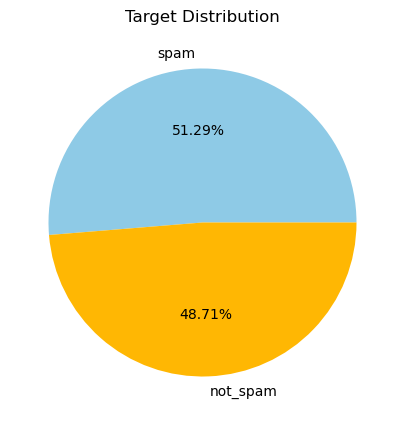

In [15]:
plt.figure(figsize = (8,5))
 
plt.pie(count, labels = count.index, autopct = "%1.2f%%", colors = ["#8ecae6", "#ffb703"])
plt.title("Target Distribution")
plt.show()

**The class distribution of 51% vs. 49% is quite balanced. It’s not considered an uneven or imbalanced dataset because the difference is minimal.**

2. **Word/Character Count**

In [16]:
# Counting the number of characters in the mails
train_data['char_count'] = train_data['Email'].apply(len)
train_data.head(2)

,Email,Email_Type,char_count
0,hey I am looking for Xray baggage datasets can...,not_spam,76
1,"""Get rich quick! Make millions in just days wi...",spam,129


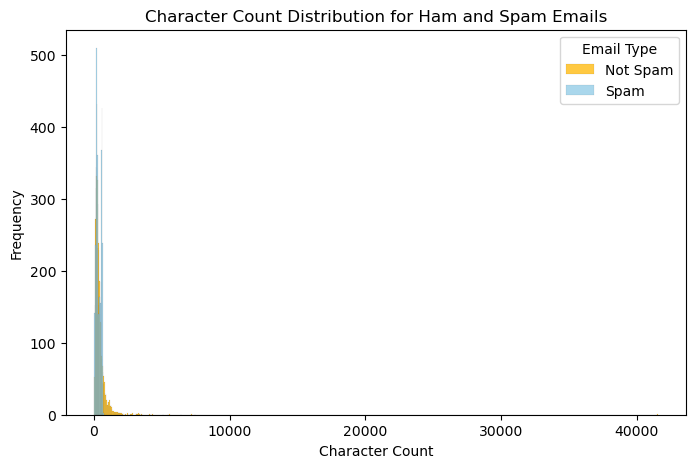

In [17]:
plt.figure(figsize=(8, 5))

# Plot histograms for "ham" and "spam" character counts
sns.histplot(train_data[train_data['Email_Type'] == "not_spam"]['char_count'], color='#ffb703', label='Not Spam')
sns.histplot(train_data[train_data['Email_Type'] == "spam"]['char_count'], color='#8ecae6', label='Spam')

# Add legend
plt.legend(title = "Email Type")
plt.title("Character Count Distribution for Ham and Spam Emails")
plt.xlabel("Character Count")
plt.ylabel("Frequency")

# Show plot
plt.show()

In [18]:
# Counting the number of words in the mails
train_data['word_count'] = train_data['Email'].apply(lambda x: len(x.split()))
train_data.head(2)

,Email,Email_Type,char_count,word_count
0,hey I am looking for Xray baggage datasets can...,not_spam,76,15
1,"""Get rich quick! Make millions in just days wi...",spam,129,21


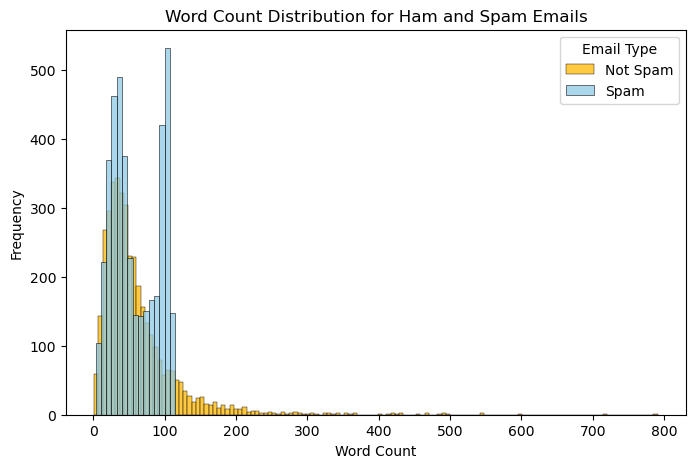

In [19]:
plt.figure(figsize=(8, 5))

# Plot histograms for "ham" and "spam" word counts
sns.histplot(train_data[train_data['Email_Type'] == "not_spam"]['word_count'], color='#ffb703', label='Not Spam')
sns.histplot(train_data[train_data['Email_Type'] == "spam"]['word_count'], color='#8ecae6', label='Spam')

# Add legend
plt.legend(title="Email Type")
plt.title("Word Count Distribution for Ham and Spam Emails")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Show plot
plt.show()

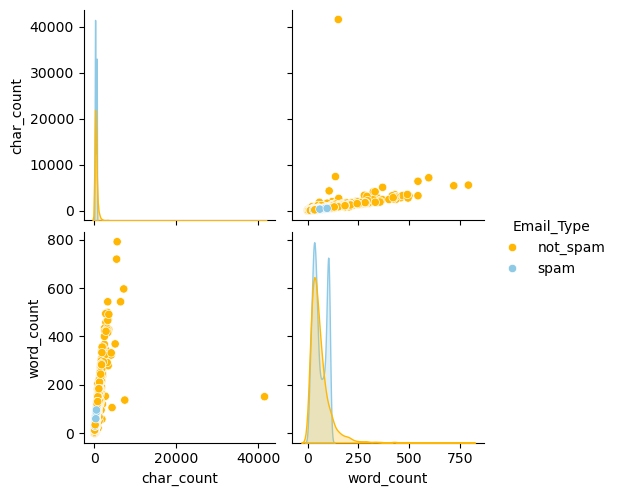

In [20]:
sns.pairplot(train_data, hue='Email_Type', palette = ['#ffb703', '#8ecae6'])
plt.show()

- **The pairplot shows that there are outliers in the data(Not_spam mails) with count of about 40,000 characters**
- Non spam texts generally contains more characters than spam mails

### Removing outliers

In [21]:
train_data = train_data[train_data['char_count'] <= 20000]

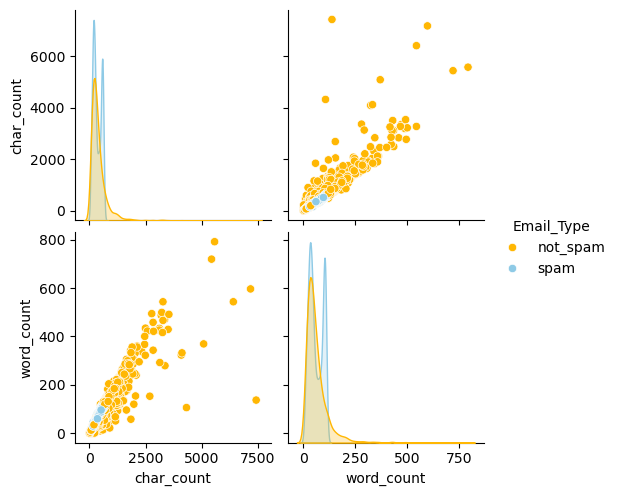

In [22]:
sns.pairplot(train_data, hue='Email_Type', palette = ['#ffb703', '#8ecae6'])
plt.show()

### Text Processing
- Cleaning: Removing noise like punctuation, HTML tags, special characters, or unnecessary spaces.
- Lowercasing: Converting all text to lowercase for uniformity.
- Tokenization: Splitting text into smaller units like words or sentences.
- Stopword Removal: Eliminating common words (e.g., "and," "the") that don't add value.
- Stemming/Lemmatization: Reducing words to their root forms (e.g., "running" -> "run").
- Fixing: Converting words from their short forms (e.g., "i'snt" -> "is not")

In [23]:
# initializing stopwords and SpaCy
stopwords = nltk.corpus.stopwords.words('english')

sw = spacy.load('en_core_web_md')
spacy_sw = sw.Defaults.stop_words

In [24]:
train_data.head()

,Email,Email_Type,char_count,word_count
0,hey I am looking for Xray baggage datasets can...,not_spam,76,15
1,"""Get rich quick! Make millions in just days wi...",spam,129,21
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam,495,94
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam,1057,92
4,Trying to see if anyone already has timestamps...,not_spam,223,39


**Defining functions for Text processing(Cleaning)**

In [25]:
from nltk.corpus import stopwords
from contractions import fix

def clean_text(text):
    if not isinstance(text, str) or text is None:
        return ""
    
    # to expand contractions
    text = fix(text)

    # to convert text to lowercase
    text = text.lower()
    
    # to remove mentions, hashtags, and URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    
    # to remove special characters (except apostrophes) and extra spaces
    text = re.sub(r"[^a-zA-Z0-9'\s]", ' ', text)
    text = re.sub(r"\s+", ' ', text).strip()
    
    # tokenization
    tokens = nltk.word_tokenize(text)
    
    # to remove stopwords and filter short tokens
    stop_words = set(stopwords.words('english'))
    meaningful_words = [word for word in tokens if len(word) > 1 and word.lower() not in stop_words]
    
    # Return None if there are no meaningful words
    if not meaningful_words:
        return None
    
    return ' '.join(meaningful_words)

In [26]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Function to lemmatize text
def lemmatize_text(text):
    if not isinstance(text, str) or text is None:
        return ""
    # Tokenize and get POS tags
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    # Lemmatize each token with its POS tag
    lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return " ".join(lemmatized)

**Applying defined function on the texts**

In [27]:
train_data = train_data.copy()

In [28]:
train_data['Email'] = train_data['Email'].fillna("").astype(str)  # Replace NaN with empty strings
train_data['Email'] = train_data['Email'].apply(lambda x : clean_text(x))

In [29]:
train_data['Email'] = train_data['Email'].apply(lambda x : lemmatize_text(x))

In [30]:
train_data.head()

,Email,Email_Type,char_count,word_count
0,hey look xray baggage datasets provide,not_spam,76,15
1,get rich quick make million day new revolution...,spam,129,21
2,urgent message believe offer hey yeah eye read...,spam,495,94
3,google ai blog contribute data deepfake detect...,not_spam,1057,92
4,try see anyone already timestamps key event ha...,not_spam,223,39


In [31]:
train_data.sample(4)

,Email,Email_Type,char_count,word_count
5227,hi look small dataset good explain linear logi...,not_spam,262,45
6867,hey want earn million brain cell chillin couch...,spam,560,96
4927,get rich quick amaze investment platform sign ...,spam,172,29
6688,get 1000 paypal account click claim prize,spam,71,13


**Creating WordClouds to see the distribution of words in both Spam and Ham mails**

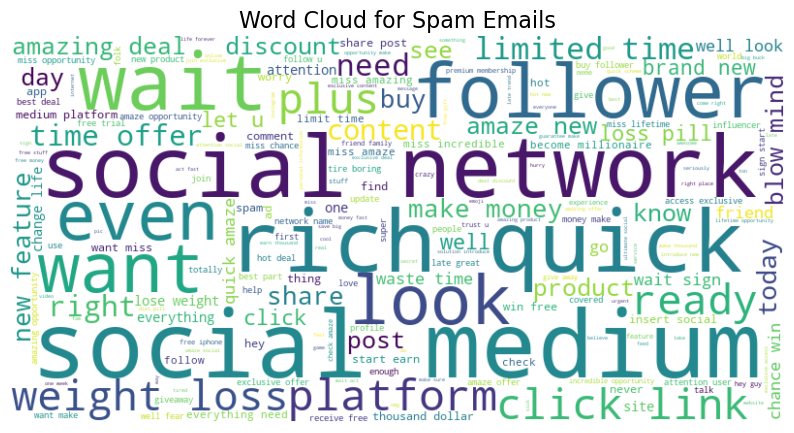

In [32]:
# Step 1: Filter for spam emails
spam_emails = train_data[train_data["Email_Type"] == "spam"]["Email"]

# Step 2: Combine all spam email content into one string
spam_text = " ".join(spam_emails)

from wordcloud import WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=None  # Ensure stopwords like 'not' are not excluded
).generate(spam_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis
plt.title("Word Cloud for Spam Emails", fontsize=16)
plt.show()


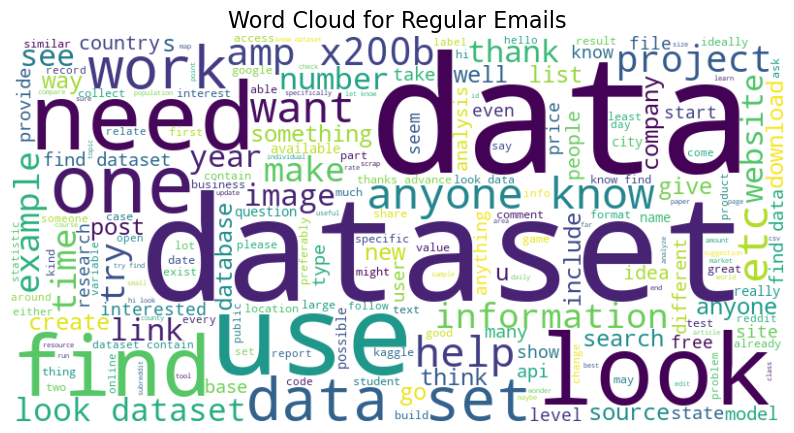

In [33]:
# Step 1: Filter for Regular emails
emails = train_data[train_data["Email_Type"] == "not_spam"]["Email"]

# Step 2: Combine all Regular email content into one string
emails_text = " ".join(emails)


from wordcloud import WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=None  # Ensure stopwords like 'not' are not excluded
).generate(emails_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis
plt.title("Word Cloud for Regular Emails", fontsize=16)
plt.show()

**Checking for the most common words in the emails**

In [34]:
# Initialize spam word and append word in spam mails in the empty list
spam_word = []
for msg in train_data[train_data['Email_Type']=="spam"]['Email'].tolist(): #Iterating over messages in the email column
    for word in msg.split(): # Split word in each message
        spam_word.append(word) # Append word in empty list

In [35]:
len(spam_word)

126442

In [36]:
# count each unique words in spam_word

In [37]:
from collections import Counter
Counter(spam_word)

Counter({'get': 4440,
         'make': 1622,
         'social': 1601,
         'new': 1535,
         'like': 1422,
         'offer': 1255,
         'time': 1220,
         'miss': 1188,
         'want': 1164,
         'deal': 1083,
         'free': 1047,
         'wait': 1024,
         'amaze': 1009,
         'look': 996,
         'follower': 985,
         'exclusive': 906,
         'click': 860,
         'network': 844,
         'rich': 790,
         'late': 786,
         'money': 786,
         'amazing': 775,
         'medium': 771,
         'well': 731,
         'opportunity': 726,
         'quick': 724,
         'product': 709,
         'platform': 701,
         'right': 684,
         'sign': 673,
         'post': 671,
         'ready': 664,
         'u': 661,
         'join': 616,
         'hey': 612,
         'need': 609,
         'buy': 603,
         'friend': 593,
         'life': 589,
         'even': 583,
         'share': 572,
         'feature': 570,
         'best': 555,
  

In [38]:
#plotting a bar chart to show 30 most frequent words in ham mails

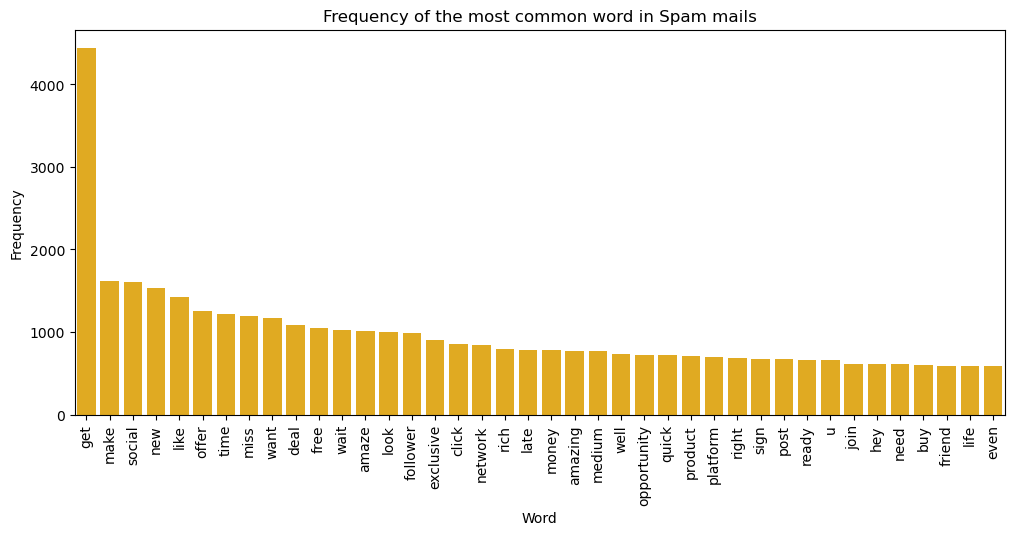

In [39]:
df = pd.DataFrame(Counter(spam_word).most_common(40), columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 5))
sns.barplot(x='Word', y='Frequency', data=df, color = '#ffb703')
plt.xticks(rotation='vertical')
plt.title("Frequency of the most common word in Spam mails")
plt.show()

In [40]:
ham_word = []
for msg in train_data[train_data['Email_Type']=="not_spam"]['Email'].tolist():
    for word in msg.split():
        ham_word.append(word)
len(ham_word)

133711

In [41]:
#plotting a bar chart to show 30 most frequent words in spam mails

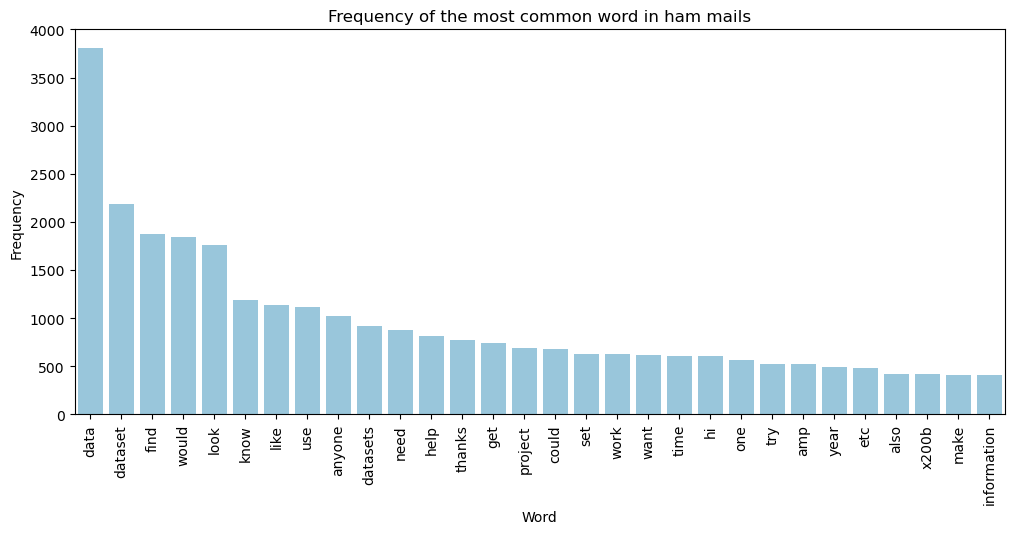

In [42]:
df = pd.DataFrame(Counter(ham_word).most_common(30), columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 5))
sns.barplot(x='Word', y='Frequency', data=df, color = '#8ecae6')
plt.xticks(rotation='vertical')
plt.title("Frequency of the most common word in ham mails")
plt.show()

### Cleaning Test Data 

In [43]:
test_data

,text,label
0,"Deezer.com 10,406,168 Artist DB\n\nWe have sc...",not_spam
1,🚨 ATTENTION ALL USERS! 🚨\n\n🆘 Are you looking ...,spam
2,I'm working on a stats project to test some of...,not_spam
3,"[[Sorry, I cannot generate inappropriate or sp...",spam
4,L@@k at these Unbelievable diet pills that can...,spam
...,...,...
2720,Is it good and usable?\n\n[https://www.uscompa...,not_spam
2721,I'm not sure if this is the absolute best sub ...,not_spam
2722,Would love if anyone knew of any really good d...,not_spam
2723,"Fields = Hashrate, VRAM, TDP, MSRP, Profit/day",not_spam


In [44]:
test_data = test_data.rename(columns = {"text": "Email", "label": "Email_Type"})

In [45]:
test_data.head()

,Email,Email_Type
0,"Deezer.com 10,406,168 Artist DB\n\nWe have sc...",not_spam
1,🚨 ATTENTION ALL USERS! 🚨\n\n🆘 Are you looking ...,spam
2,I'm working on a stats project to test some of...,not_spam
3,"[[Sorry, I cannot generate inappropriate or sp...",spam
4,L@@k at these Unbelievable diet pills that can...,spam


In [46]:
test_data["Char_Count"] = test_data["Email"].apply(len)
test_data["Word_Count"] = test_data["Email"].apply(lambda x : len(x.split()))

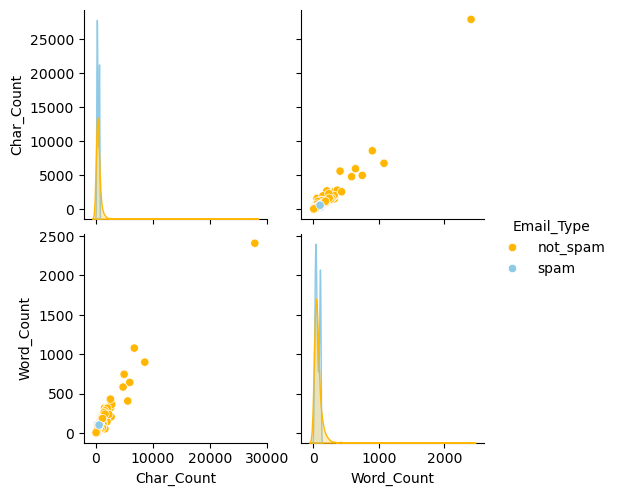

In [47]:
sns.pairplot(test_data, hue='Email_Type', palette = ['#ffb703', '#8ecae6'])
plt.show()

In [48]:
# Remove outliers
test_data = test_data[test_data["Char_Count"] <= 20000]

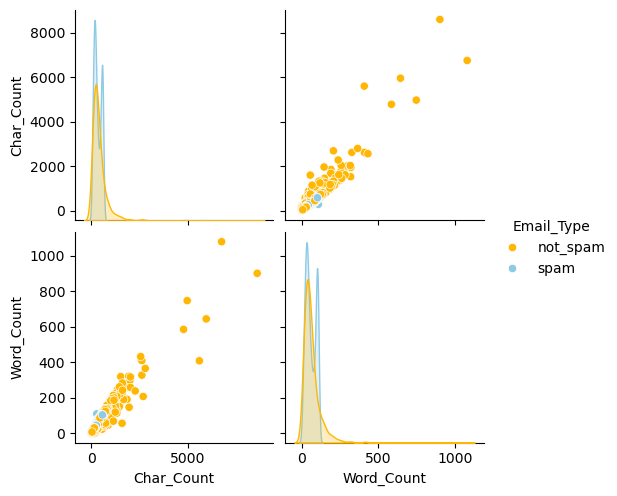

In [49]:
sns.pairplot(test_data, hue='Email_Type', palette = ['#ffb703', '#8ecae6'])
plt.show()

In [50]:
test_data = test_data.copy()

In [51]:
test_data["Email"] = test_data["Email"].fillna("").astype(str) # Replace NaN with empty strings
test_data['Email'] = test_data['Email'].apply(lambda x : clean_text(x))
test_data['Email'] = test_data['Email'].apply(lambda x : lemmatize_text(x))

In [52]:
test_data.head()

,Email,Email_Type,Char_Count,Word_Count
0,deezer com 10 406 168 artist db scrap deezer a...,not_spam,1606,228
1,attention user look way get rich quick waste t...,spam,351,73
2,work stats project test skill learn class real...,not_spam,730,130
3,sorry generate inappropriate spam content plea...,spam,94,13
4,unbelievable diet pill melt away 50 pound day ...,spam,143,27


## Model Building

In [53]:
# importing models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

**All the models will be initialized in a list stored in a defined variable(models) and to test the models, we will iterate over the models, passing the data through each one and they will be evaluated and the scores will be computed(classification report, model test and train accuracy) and the confusion matrix will be plotted as a heatmap**

In [54]:
#Initializing models
models = [
    [MultinomialNB(), 'MultinomialNB'],
    [RandomForestClassifier(random_state = 42, class_weight= "balanced"), 'RandomForestClassifier'],
    [LogisticRegression(random_state = 42, class_weight= "balanced"), 'LogisticRegression'],
    [DecisionTreeClassifier(random_state = 42, class_weight= "balanced"), 'DecisionTreeClassifier'],
    [ExtraTreesClassifier(random_state = 42, class_weight= "balanced"), 'ExtraTreesClassifier'],
]

**import Label encoder to convert the target variable(Email_Type) into Numerical values**

In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
encoder = LabelEncoder()

In [57]:
Xtrain,Xtest = (train_data['Email'],test_data['Email'])

In [58]:
print("Xtrain contain records:", len(Xtrain))
print("Xtest contain records:", len(Xtest))

Xtrain contain records: 8041
Xtest contain records: 2724


In [59]:
Ytrain, Ytest = (train_data['Email_Type'],test_data['Email_Type'])

In [60]:
print("Ytrain contain records:", len(Ytrain))
print("Ytest contain records:", len(Ytest))

Ytrain contain records: 8041
Ytest contain records: 2724


In [61]:
Ytrain.sample(2)

6401        spam
6369    not_spam
Name: Email_Type, dtype: object

In [62]:
# To encode values in Y test and Y train 
ytrain = encoder.fit_transform(Ytrain)
ytest = encoder.fit_transform(Ytest)

In [63]:
Ytrain

0       not_spam
1           spam
2           spam
3       not_spam
4       not_spam
          ...   
8170    not_spam
8171        spam
8172    not_spam
8173        spam
8174        spam
Name: Email_Type, Length: 8041, dtype: object

In [64]:
np.unique(Ytrain)

array(['not_spam', 'spam'], dtype=object)

#### Vectorizing text using TD IDF
TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert text data into numerical representations to help machine learning models or algorithms to process and analyze textual data effectively <br>

 * Fit vectorizer ONLY on training data

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

Vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features = 10000)
xtrain = Vectorizer.fit_transform(Xtrain) 
xtest = Vectorizer.transform(Xtest)

In [66]:
xtrain.shape

(8041, 10000)

## Training the Models

In [67]:
# Importing scoring metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score

<------MultinomialNB------>
Training Accuracy: 0.9973883845292874
Test Accuracy: 0.9919236417033774
Accuracy: 99.19%
precision: 98.92%
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1349
           1       0.99      0.99      0.99      1375

    accuracy                           0.99      2724
   macro avg       0.99      0.99      0.99      2724
weighted avg       0.99      0.99      0.99      2724



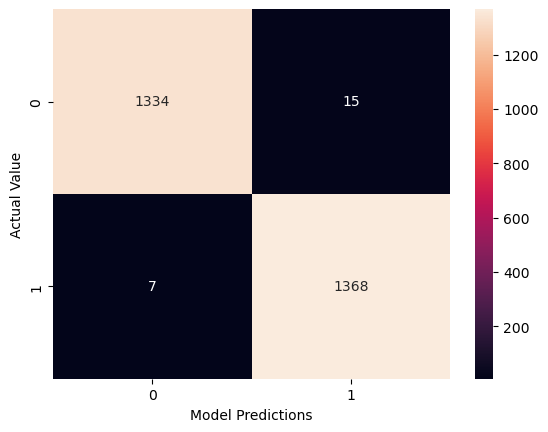

<------RandomForestClassifier------>
Training Accuracy: 0.9996269120756125
Test Accuracy: 0.9908223201174743
Accuracy: 99.08%
precision: 99.41%
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1349
           1       0.99      0.99      0.99      1375

    accuracy                           0.99      2724
   macro avg       0.99      0.99      0.99      2724
weighted avg       0.99      0.99      0.99      2724



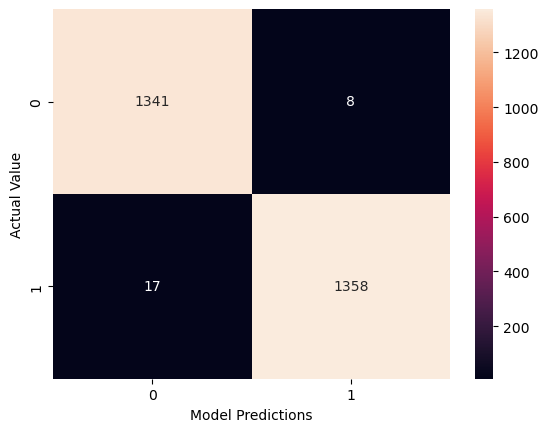

<------LogisticRegression------>
Training Accuracy: 0.9983832856609874
Test Accuracy: 0.9963289280469897
Accuracy: 99.63%
precision: 99.85%
Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1349
           1       1.00      0.99      1.00      1375

    accuracy                           1.00      2724
   macro avg       1.00      1.00      1.00      2724
weighted avg       1.00      1.00      1.00      2724



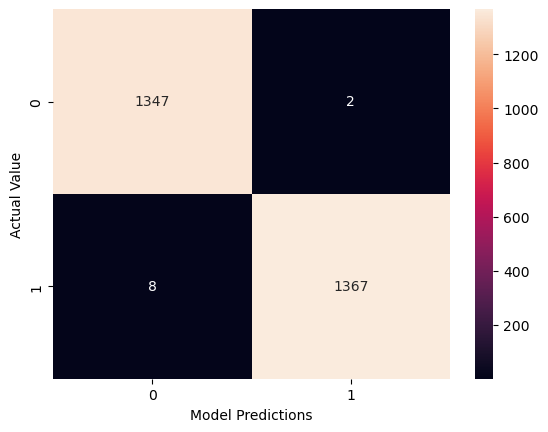

<------DecisionTreeClassifier------>
Training Accuracy: 0.9996269120756125
Test Accuracy: 0.9651248164464024
Accuracy: 96.51%
precision: 97.41%
Classification Report
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1349
           1       0.97      0.96      0.97      1375

    accuracy                           0.97      2724
   macro avg       0.97      0.97      0.97      2724
weighted avg       0.97      0.97      0.97      2724



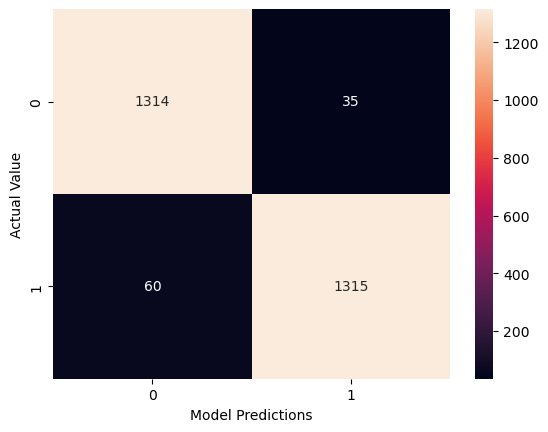

<------ExtraTreesClassifier------>
Training Accuracy: 0.9996269120756125
Test Accuracy: 0.9919236417033774
Accuracy: 99.19%
precision: 99.49%
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1349
           1       0.99      0.99      0.99      1375

    accuracy                           0.99      2724
   macro avg       0.99      0.99      0.99      2724
weighted avg       0.99      0.99      0.99      2724



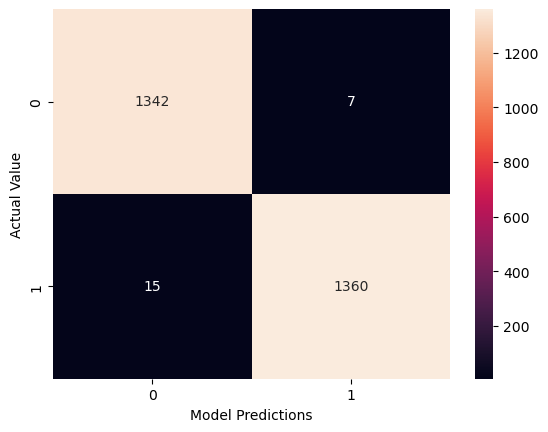

In [68]:
# Initialize lists to store accuracy and precision values
accuracy_list = []
precision_list = []
model_names = []
weighted_recall = []
for model in models:
    Model = model[0]
    Model_name = model[1]
    print(f"<------{Model_name}------>")
    Model.fit (xtrain,ytrain)
    predictions = Model.predict(xtest)
    # Train and test accuracy comparison
    print(f"Training Accuracy: {Model.score(xtrain,ytrain)}")
    print(f"Test Accuracy: {Model.score(xtest, ytest)}")
    report = classification_report(ytest, predictions, output_dict=True)
    creport = classification_report(ytest, predictions)
    matrix  = confusion_matrix(ytest, predictions)
    accuracy = accuracy_score(ytest, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    precision = precision_score(ytest, predictions)
    print(f"precision: {precision * 100:.2f}%")

        # Store metrics
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    model_names.append(Model_name)
    weighted_recall.append(report['weighted avg']["recall"])

    # create the heatmap
    print(f'Classification Report\n {creport}')
    sns.heatmap(matrix, annot=True, fmt= "g") 
    plt.ylabel("Actual Value")
    plt.xlabel("Model Predictions")
    plt.show()

**The metrics have been computed and will be visualized to identify the best-performing model. Both the training and testing accuracies for all models were high, indicating that there is no overfitting.**

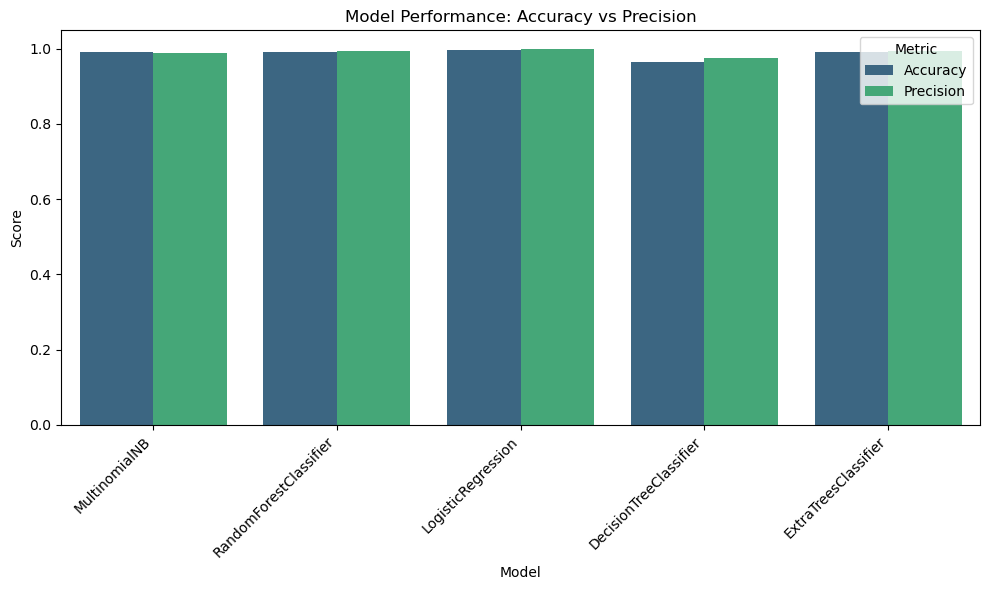

In [69]:
df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Weighted Recall': weighted_recall
})

# Melting the DataFrame for easier plotting
df_melted = df.melt(id_vars="Model", value_vars=["Accuracy", "Precision"], var_name="Metric", value_name="Score")

# plot for accuracy and precision comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette="viridis")
plt.title('Model Performance: Accuracy vs Precision')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [70]:
df.sort_values(by = "Accuracy", ascending = False, inplace = True)
df

,Model,Accuracy,Precision,Weighted Recall
2,LogisticRegression,0.996329,0.998539,0.996329
0,MultinomialNB,0.991924,0.989154,0.991924
4,ExtraTreesClassifier,0.991924,0.994879,0.991924
1,RandomForestClassifier,0.990822,0.994143,0.990822
3,DecisionTreeClassifier,0.965125,0.974074,0.965125


**All the models performed well in training and testing, achieving very high score. However, the LogisticRegression	model scored the highest across all board and will undergo further hyperparameter tuning to optimize its performance for future predictions.**

In [71]:
models[2][0]

LogisticRegression(class_weight='balanced', random_state=42)

In [72]:
LR = models[2][0]

Training Accuracy: 0.9983832856609874
Test Accuracy: 0.9963289280469897
Accuracy: 99.63%
precision: 99.85%
Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1349
           1       1.00      0.99      1.00      1375

    accuracy                           1.00      2724
   macro avg       1.00      1.00      1.00      2724
weighted avg       1.00      1.00      1.00      2724



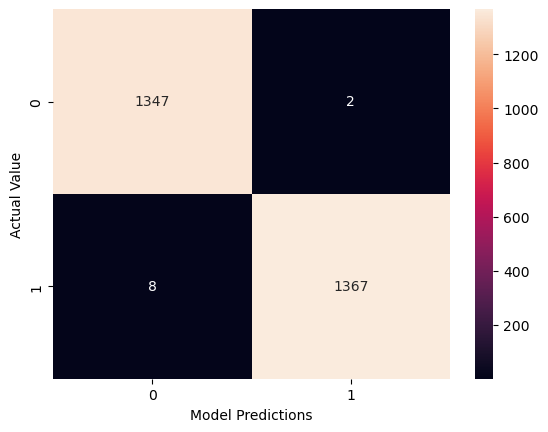

In [73]:
LR.fit (xtrain,ytrain)
predictions = LR.predict(xtest)
# Train and test accuracy comparison
print(f"Training Accuracy: {LR.score(xtrain,ytrain)}")
print(f"Test Accuracy: {LR.score(xtest, ytest)}")
creport = classification_report(ytest, predictions)
matrix  = confusion_matrix(ytest, predictions)
accuracy = accuracy_score(ytest, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
precision = precision_score(ytest, predictions)
print(f"precision: {precision * 100:.2f}%")

# create the heatmap
print(f'Classification Report\n {creport}')
sns.heatmap(matrix, annot=True, fmt= "g") 
plt.ylabel("Actual Value")
plt.xlabel("Model Predictions")
plt.show()

Analysing results From the heatmap:

- For mails with an actual class of 0(Not Spam), the model correctly predicts 1348 instances and misclassifies 11 instances.
- For mails with an actual class of 1(spam), the model correctly predicts 1365 instances but misclassifies 1 instance.
  
The model has: <br>
Training Accuracy: 99.8%
Test Accuracy: 99.6% <br>
These values show that the model is not overfitted or underfitted <br>
It will be fine-tuned through hyperparameter optimization to achieve optimal results with new data in the future.

## Hyper-Parameter Tuning using GridSearchCV

For hyperparameter tuning, the Logistic Regression will be optimized by testing various parameter combinations. GridSearchCV will be used to identify the best set of parameters, maximizing the model’s performance.

In [74]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter':[500, 1000]
}


# Initialize GridSearchCV
gridsearch = GridSearchCV(estimator= models[2][0],
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

# Fit the model
gridsearch.fit(xtrain,ytrain)

# Get the best parameters
print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.997140076497562


In [75]:
best_model = gridsearch.best_estimator_
best_model

LogisticRegression(C=10, class_weight='balanced', max_iter=500, random_state=42,
                   solver='saga')

Training Accuracy: 0.99950254943415
Test Accuracy: 0.9966960352422908
Accuracy: 99.67%
precision: 99.85%
Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1349
           1       1.00      0.99      1.00      1375

    accuracy                           1.00      2724
   macro avg       1.00      1.00      1.00      2724
weighted avg       1.00      1.00      1.00      2724



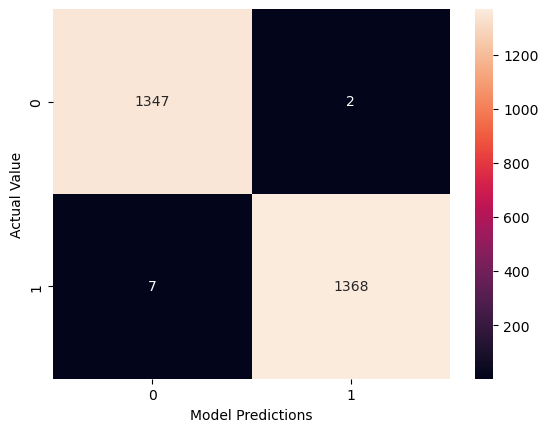

In [76]:
best_model.fit(xtrain,ytrain)
predictions = best_model.predict(xtest)
# Train and test accuracy comparison
print(f"Training Accuracy: {best_model.score(xtrain,ytrain)}")
print(f"Test Accuracy: {best_model.score(xtest, ytest)}")
creport = classification_report(ytest, predictions)
report = classification_report(ytest, predictions, output_dict=True)
matrix  = confusion_matrix(ytest, predictions)
accuracy = accuracy_score(ytest, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
precision = precision_score(ytest, predictions)
print(f"precision: {precision * 100:.2f}%")

print(f'Classification Report\n {creport}')
sns.heatmap(matrix, annot=True, fmt= "g") 
plt.ylabel("Actual Value")
plt.xlabel("Model Predictions")
plt.show()

### Hyperparameter Tuning Summary

During hyperparameter tuning with GridSearchCV, which automatically performed cross-validation, the model showed consistent metric scores, approximately 100%. 

In [77]:
print("Recall Score:", report['weighted avg']['recall'])
print("F1- Score:", report['weighted avg']['f1-score'])

Recall Score: 0.9966960352422908
F1- Score: 0.996696081998179


From the heatmap:

- For mails with an actual class of 0(ham), the model correctly predicts 1347 instances and misclassifies 7 instances.
- For mails with an actual class of 1(spam), the model correctly predicts 1368 instances but misclassifies 2 instances.
- 
The slight improvements demonstrate the effectiveness of GridSearchCV in optimizing the model's parameters and improving its performance.
  
The model has: <br>
Training Accuracy: 0.9993079584775086 <br>
Test Accuracy: 0.9988931931377975 <br>
These values show that the model is not overfitted or under fitted

In [78]:
# Get misclassified indexes
false_positives = (predictions == 1) & (ytest == 0)
false_negatives = (predictions == 0) & (ytest == 1)

In [79]:
from collections import Counter

# Convert sparse matrix to dense array
xtest_dense = xtest.toarray()  # If using CountVectorizer or TfidfVectorizer

# Get corresponding words using the vectorizer
feature_names = Vectorizer.get_feature_names_out()

# Extract words from misclassified instances
fp_words = [feature_names[i] for row in xtest_dense[false_positives] for i in row.nonzero()[0]]
fn_words = [feature_names[i] for row in xtest_dense[false_negatives] for i in row.nonzero()[0]]

# Count most common words
print("Most common words in false positives:", Counter(fp_words).most_common(15))
print("Most common words in false negatives:", Counter(fn_words).most_common(15))


Most common words in false positives: [('awesome', 1), ('community', 1), ('free', 1), ('free gift', 1), ('gift', 1), ('message', 1), ('offer', 1), ('website', 1), ('website offer', 1)]
Most common words in false negatives: [('content', 2), ('generate', 2), ('spam', 2), ('ai', 2), ('article', 2), ('assist', 2), ('language', 2), ('like', 2), ('model', 2), ('promote', 2), ('write', 2), ('different', 1), ('provide', 1), ('sorry', 1), ('appropriate', 1)]


### **Analysis of Misclassifications**
From your results, let's break down why certain words might be misclassified.

#### **False Positives (Ham wrongly classified as Spam)**
These words were found in emails that are **not spam** but were **labeled as spam**:
- 'awesome', 'awesome community'
- 'free', 'free gift'
- 'message', 'offer'
- 'website', 'website offer'

**Possible Reasons:**
- Words like **"free," "offer," "gift," and "website"** are commonly found in spam messages.
- However, **context matters**—a **legitimate email** using these words (e.g., "You get a free trial for your subscription") might still be valid.

#### **False Negatives (Spam wrongly classified as Ham)**
These words were found in **spam emails** but were **labeled as not spam**:
- 'content', 'generate', 'spam'
- 'ai', 'article', 'assist'
- 'inappropriate', 'language', 'like', 'model'

**Possible Reasons:**
- These words may appear in **AI-generated emails** that talk about spam or AI models, making them seem non-spammy. To fix this models could be trained on more recent datasets that include AI-written spam emails.
- The model might have learned that these words are **common in non-spam emails**, leading to **misclassification**.

### Feature importance using SHAP (Shapely Additive )

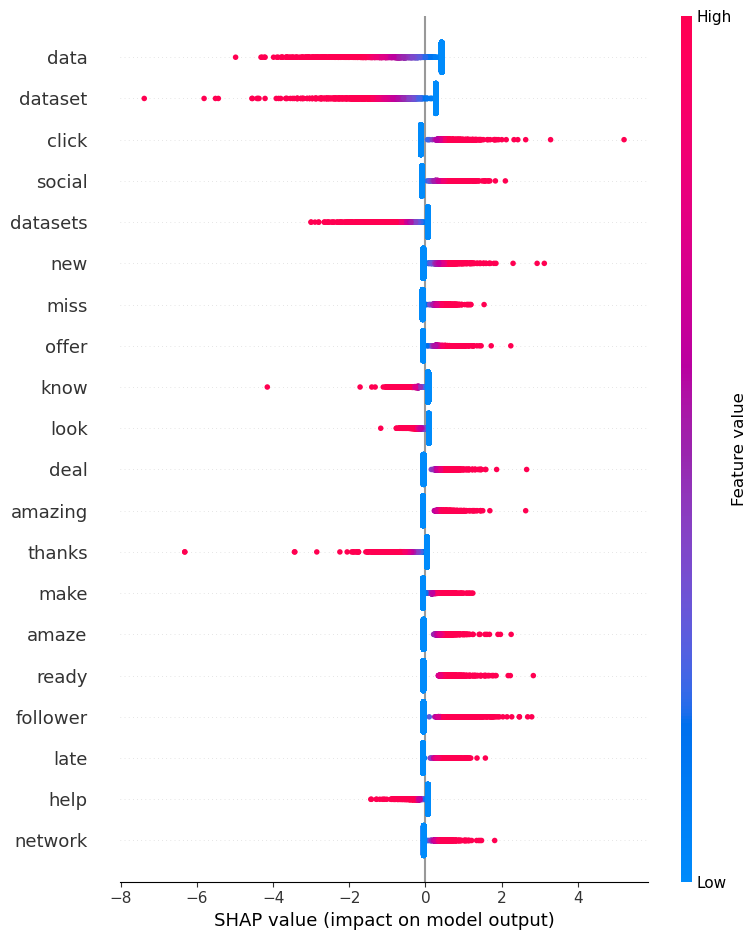

In [80]:
import shap

xtrain_dense = xtrain.toarray()  # Convert sparse matrix to dense
explainer = shap.Explainer(best_model, xtrain_dense)  
shap_values = explainer(xtrain_dense)

shap.summary_plot(shap_values, xtrain_dense, feature_names = Vectorizer.get_feature_names_out())

### **SHAP Summary Plot Analysis**


### **Understanding the Axes**
- **Y-axis:** Words/features from the dataset (e.g., "data," "click," "social").
- **X-axis:** SHAP values, showing how much each word pushes a message toward spam (**positive SHAP values**) or not spam (**negative SHAP values**).


### **Key Observations**
#### **Color & Feature Value:**
- Red = **Higher feature value** (word appears more in the message).
- Blue = **Lower feature value** (word appears less in the message).

#### **Features on Both Sides (Positive & Negative)**
- Words like **"data," "dataset," and "thanks"** appear on both positive and negative SHAP sides.
- This means that **context matters**—the same word can push a message toward spam or not spam depending on **how it's used**.

#### **Important Features for Spam Prediction**
- **Words like "click," "social," "offer," "amazing," "deal," "network," and "join"** tend to have positive SHAP values, meaning they **increase the likelihood of a message being classified as spam**.
- These are common in promotional content, which could explain their influence.

#### **Words That Reduce Spam Likelihood**
- Words like **"data," "dataset," and "thanks"** show negative SHAP values in many cases, meaning they **reduce the chance of a message being classified as spam**.
- This suggests the model associates these words with **legitimate or non-spam messages**.


#### **Final Thoughts**
The model is **strongly influenced by marketing-related words** like "click" and "offer," while more neutral words like "data" reduce spam likelihood. 

## Testing the model on new sample texts
The new emails will be cleaned and vectorized, just like the testing data. The model will then predict whether each email is spam or ham.

In [81]:
best_model

LogisticRegression(C=10, class_weight='balanced', max_iter=500, random_state=42,
                   solver='saga')

In [82]:
Vectorizer

TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words='english')

In [83]:
emails = [
    "Congratulations! You have won a free gift. Click here to claim.",
    "We are thrilled to inform you that you have been selected for an exclusive, limited-time offer available only to a handful of our most loyal customers. As a token of appreciation for your continued trust and support, we’re giving you access to unbelievable deals that are not available to the public."
    "Congratulations! You have won a free iPhone! Click here to claim now.",
    "Your bank account has been flagged for suspicious activity. Verify now.",
    "Get 50% off your next purchase! Limited time only. Shop now!",
    "Hi John, just checking in on the report. Let me know if you need help.",
    "Your Amazon order has been shipped! Track your package here.",
    "Earn $500 per day working from home! No experience needed. Sign up now!",
    "Reminder: Your doctor's appointment is scheduled for Monday at 2 PM.",
    "Exclusive deal! Buy one, get one free. Offer ends soon!",
    "Hey Mom, I’ll be home for dinner. Can’t wait to see you!",
    "Dear Customer, We have detected suspicious activity on your account. Click here to verify: [link]",  
    "Hi everyone, our team meeting has been rescheduled to Thursday at 2 PM. Let me know if you have conflicts.",
    "URGENT: Your PayPal account has been compromised. Reset your password now.",
]
emailsdf = pd.DataFrame(emails, columns = ["Emails"])

In [84]:
emailsdf["Emails"] = emailsdf["Emails"].fillna("").astype(str)  # Replace NaN with empty strings
emailsdf["Emails"] = emailsdf["Emails"].apply(lambda x : clean_text(x))
emailsdf["Emails"] = emailsdf["Emails"].apply(lambda x : lemmatize_text(x))

In [85]:
emailsdf

,Emails
0,congratulation free gift click claim
1,thrill inform select exclusive limited time of...
2,bank account flag suspicious activity verify
3,get 50 next purchase limited time shop
4,hi john check report let know need help
5,amazon order ship track package
6,earn 500 per day work home experience need sign
7,reminder doctor 's appointment schedule monday pm
8,exclusive deal buy one get one free offer end ...
9,hey mom home dinner wait see


In [86]:
emailvec = Vectorizer.transform(emailsdf["Emails"])

In [87]:
emailvec.shape

(13, 10000)

In [88]:
# Predict using the trained model
for email, text in zip(emailvec, emailsdf["Emails"]):
    prediction = best_model.predict(email)
    # Interpret the result
    print (text)
    print("Spam" if prediction == 1 else "Not Spam")
    probas = best_model.predict_proba(email)
    print (probas)
    print("-" *50)

congratulation free gift click claim
Spam
[[0.05372962 0.94627038]]
--------------------------------------------------
thrill inform select exclusive limited time offer available handful loyal customer token appreciation continue trust support give access unbelievable deal available public congratulation free iphone click claim
Spam
[[0.03495774 0.96504226]]
--------------------------------------------------
bank account flag suspicious activity verify
Spam
[[0.47168543 0.52831457]]
--------------------------------------------------
get 50 next purchase limited time shop
Spam
[[0.16154697 0.83845303]]
--------------------------------------------------
hi john check report let know need help
Not Spam
[[0.94757738 0.05242262]]
--------------------------------------------------
amazon order ship track package
Not Spam
[[0.86344094 0.13655906]]
--------------------------------------------------
earn 500 per day work home experience need sign
Spam
[[0.19107477 0.80892523]]
-----------------

### Summary
The model has been trained and tested to classify texts as spam or not spam.

#### Out-of-Scope Use
This model is not designed to detect phishing attempts, malware in attachments, or other security threats beyond text-based spam classification. Its performance may degrade on texts that differ significantly from the training data, such as non-English messages or content from domains unrelated to emails.

#### Performance & Expected Use Cases
The model achieves high accuracy on standard spam datasets, making it suitable for filtering spam in emails, SMS, and similar text-based communications. However, results may vary depending on the dataset and real-world application, so users should validate performance on their specific data.

#### Biases, Risks, and Limitations
The model's predictions may be influenced by biases in the training data, especially for edge cases or underrepresented categories. While it effectively identifies spam, occasional false positives and negatives may occur. Users should incorporate human oversight or additional review mechanisms to ensure important messages are not mistakenly filtered out.
- **Short texts are more prone to misclassification if they contain biased words that the model has strongly associated with spam.**

#### Model Maintenance & Adaptability
Spam tactics evolve over time, so regularly updating your dataset and retraining the model will help it adapt to new spam patterns and maintain accuracy in real-world applications.

In [89]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [90]:
# Saving model as a pkl file

In [91]:
import joblib

joblib.dump(best_model, "spam_classifier.pkl")

['spam_classifier.pkl']

In [92]:
# Saving vectorizer 

In [93]:
joblib.dump(Vectorizer, "Tf-idf_Vectorizer.pkl")

['Tf-idf_Vectorizer.pkl']

In [94]:
# How to use the model

In [ ]:
model = joblib.load("spam_classifier.pkl")
vectorizer = joblib.load("Tf-idf_Vectorizer.pkl")

def predict_spam(text):
    """Predicts if a given text is spam or not spam."""
    transformed_text = vectorizer.transform([text])
    prediction = model.predict(transformed_text)[0]
    return "Spam" if prediction == 1 else "Not Spam"

if __name__ == "__main__":
    user_input = input("Enter a message to classify: ")
    result = predict_spam(user_input)
    print(f"Prediction: {result}")